## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

ha_df = pd.read_csv('ha_1.csv')
ha_df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


In [17]:
ha_df['diagnosis'] = ha_df['diagnosis'].astype(str)
ha_df['diagnosis'] = ha_df['diagnosis'].map({'No Disease': 0, 'Disease': 1})

In [6]:
X = ha_df[['age', 'chol']]
y = ha_df['diagnosis']

ct = ColumnTransformer(
    [
        ('num', 'passthrough', ['age', 'chol'])
    ]
)

logit_pipeline = Pipeline(
    [
        ('preprocessing', ct),
        ('logistic', LogisticRegression())
    ]
)

logit_pipeline.fit(X,y)

logit_model = logit_pipeline.named_steps['logistic']
intercept = logit_model.intercept_[0]
coeff_age = logit_model.coef_[0][0]
coeff_chol = logit_model.coef_[0][1]

logit = np.log(.5 / (1 - .5))
chol_55 = -(logit + intercept + coeff_age * 55) / coeff_chol
chol_90 = -(np.log(.9/(1-.9)) + intercept +coeff_age * 55) / coeff_chol

chol_55, chol_90

(367.8748897985761, 1587.7158792754062)

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [11]:
lda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lda", LinearDiscriminantAnalysis())]
)

lda_pipeline.fit(X, y)

lda_model = lda_pipeline.named_steps['lda']
intercept = lda_model.intercept_[0]
coeff_age = lda_model.coef_[0][0]
coeff_chol = lda_model.coef_[0][1]

lda = np.log(.5 / (1 - .5))
chol_55 = -(lda + intercept + coeff_age * 55) / coeff_chol
chol_55

368.23535752993837

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [22]:
svc_pipeline = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC(kernel="linear"))]
)

params = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10],
}
gscv = GridSearchCV(svc_pipeline, params, cv = 5, scoring='neg_mean_squared_error')
gscv.fit(X, y)

svc_model = gscv.best_estimator_.named_steps['svc']
intercept = svc_model.intercept_[0]
coeff_age = svc_model.coef_[0][0]
coeff_chol = svc_model.coef_[0][1]

logit = np.log(0.5/(1 - 0.5))
chol_55 = -(logit + intercept + coeff_age * 55) / coeff_chol
chol_55

312.7019395484379

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

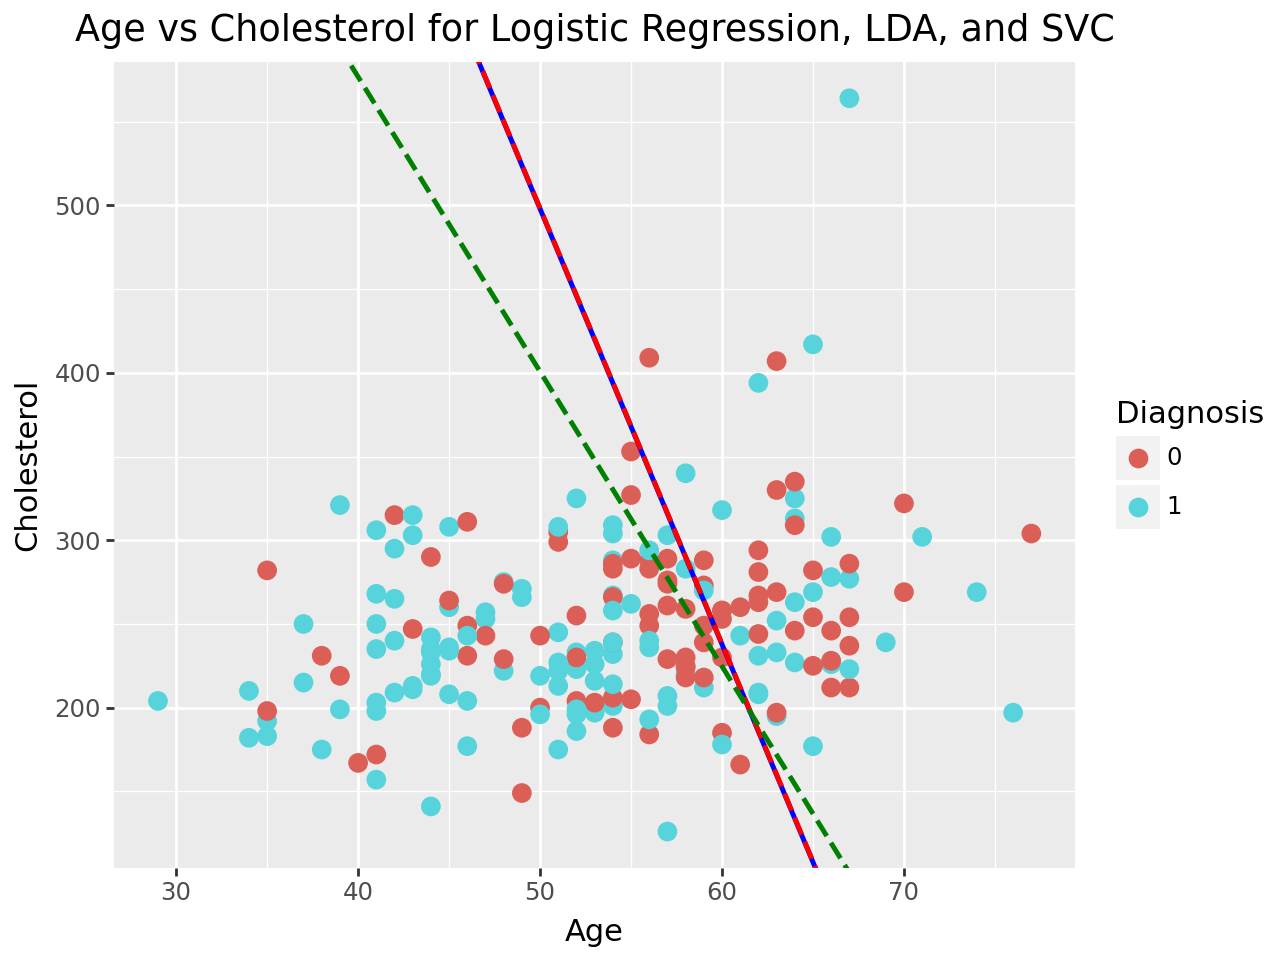

In [35]:
from plotnine import *
intercept_log = logit_model.intercept_[0]
coeff_age_log = logit_model.coef_[0][0]
coeff_chol_log = logit_model.coef_[0][1]

intercept_lda = lda_model.intercept_[0]
coeff_age_lda = lda_model.coef_[0][0]
coeff_chol_lda = lda_model.coef_[0][1]

intercept_svc = svc_model.intercept_[0]
coeff_age_svc = svc_model.coef_[0][0]
coeff_chol_svc = svc_model.coef_[0][1]

(ggplot(ha_df, aes(x='age', y='chol', color='factor(diagnosis)'))
    + geom_point(size=3)
    + geom_abline(slope=-coeff_age_log/coeff_chol_log, intercept=-intercept_log/coeff_chol_log, linetype='solid', color='blue', size=1)
    + geom_abline(slope=-coeff_age_lda/coeff_chol_lda, intercept=-intercept_lda/coeff_chol_lda, linetype='dashed', color='red', size=1)
    + geom_abline(slope=-coeff_age_svc/coeff_chol_svc, intercept=-intercept_svc/coeff_chol_svc, linetype='dashed', color='green', size=1)
    + labs(title="Age vs Cholesterol for Logistic Regression, LDA, and SVC", x="Age", y="Cholesterol", color="Diagnosis")
)

